<a href="https://colab.research.google.com/github/harvardnlp/namedtensor/blob/master/NamedTensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor Considered Harmful

*Alexander Rush* - @harvardnlp

<i>
TL;DR: Despite their ubiquity in modern frameworks, tensors are a broken programming concept . They fail at encapsulation, rely on opaque references, and force checkable properties into the documentation.  Their main benefit, perceived closeness to mathematical notation, falls apart in large code bases. This post presents a proof-of-concept of a simple alternative approach **named tensors** that forces all dimensions of a tensor to have a human-readable name. While this seems like a small change, I show that it eliminates the need for indexing, dim/axis arguments, and tricks like einsum. Furthermore, it opens up the ability for a range of dynamic error checking. The beta PyTorch library accompanying this blog post is available at [harvardnlp/namedtensor](https://github.com/harvardnlp/NamedTensor).
</i>

In [0]:
!rm -fr NamedTensor/; git clone -q https://github.com/harvardnlp/NamedTensor.git
!cd NamedTensor; pip install -q .  
!pip install -q torch numpy opt_einsum

In [0]:
import numpy 
import torch
import namedtensor as nt
from namedtensor import NamedTensor
nt._im_init()

## The Problem: Tensor Traps

The central object of mathematical frameworks like numpy, pytorch, chainer, and tensorflow is of course the tensor, a multi-dimensional array object. Let's look at a visual example of tensor. 

In [3]:
ims = torch.tensor(numpy.load('NamedTensor/examples/test_images.npy'))
ims.shape

torch.Size([6, 96, 96, 3])

So what is this object? Tensors carry around an implied tuple of their dimensions. Here there are 4, corresponding to *batch_size*, *height*, *width*, and *channels*. Most of the time you can figure this out by some comment in the code that looks like this:  

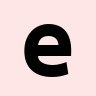

In [4]:
# batch_size x height x width x channels
ims[0]

These objects are concise, mathy, and very efficient internally. They are at the center of every modern machine learning system. However in this post I will argue that they are inherently broken.


**Reason 1: Convention instead of Encapsulation**

Code that manipulates tensors does so by indexing these dimensions. So if you want to rotate the image you read the comment, decide what needs to get changed and alter it. 

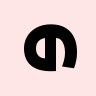

In [5]:
def rotate(ims):
    # batch_size x height x width x channels
    rotated = ims.transpose(1, 2)
    
    # batch_size x width x height x channels
    return rotated
rotate(ims)[0]



If we are honest about the semantics of this object, the *batch* dimension is private. The property of rotation is independent of the batch, or for that matter, any other private dimensions that the tensor might have. It's quite worrisome that if we pass in a singleton image this function runs fine but fails. 

In [6]:
rotate(ims[0]).shape

torch.Size([96, 3, 96])

**Reason 2: Broadcasting instead of Semantics**

Assume that we want to mask out a part of the image. We can do this using *broadcasting* by first creating a mask and then applying it across dimensions.

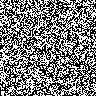

In [7]:
# height x width
mask = torch.randint(0, 2, [96, 96]).byte()
mask

In [8]:
try:
    ims.masked_fill(mask, 0)
except RuntimeError:
    print("Broadcasing fail", mask.shape, ims.shape)

Broadcasing fail torch.Size([96, 96]) torch.Size([6, 96, 96, 3])


This fails because even though we knew that we were building a *height* and *width* shaped mask, the rules of broadcasting do not have the correct semantics. To make this work, you have to use either `view` or `squeeze`.   

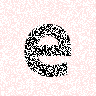

In [9]:
# either 
mask = mask.unsqueeze(-1)
# or 
mask = mask.view(96, 96, 1)

# height x width x channels
ims.masked_fill(mask, 1)[0]

This code is slightly better at encapsulation since it hides the leftmost dimensions. However reading through real code, dozens of `view`s and `squeeze`s become completely unreadable.

**Reason 3: Comments instead of Checks**



It is possible that you look at the top two issues and think that as long as you are careful, these issues will be caught by run time errors. 
However, combination of broadcasting and indexing can lead to problems that are very tough to catch.  

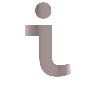

In [10]:

a = ims[1].mean(2, keepdim=True)
# height x width x 1

# (Lots of code in between)
#  .......................

# Code comment explaining what should be happening.
dim = 1
b = a + ims.mean(dim, keepdim=True)[0]


# (Or maybe should be a 2? or a 0?)
index = 2
b = a + ims.mean(dim, keepdim=True)[0]
b

Here we assume that the coder is trying to combine two tensor using both reduction operations and dimension indexing. (Honestly at this point I have forgetten the dimensions stand for). The main point though is that this code will run fine for whatever value `dim` is. The comment is useless here if the code doesn't throw a run time error. 

## An Opinionated Proposal: Named Tensors

My proposal is simple but dogmatic. Tensor is broken, we should use named tensors. Ideally:

**1) All dimensions should have a unique human-readable name. **

**2) No function should have an index-based `dim` / `axis` argument. **

**3) Implicit broadcasting should be replaced with *contraction*. **

**4) Transposition should be explicit.**

**5) Indexing should be phased out. **

**6) Knowing private dimensions should never be necessary.**



## A Prototype: The `namedtensor` Library

To experiment with these ideas I have built a library known as NamedTensor. Currently parts of it are PyTorch specific, but in theory a similar idea could be used in other frameworks. The code is available at [here](https://github.com/harvardnlp/namedtensor). Let's go through how each of these ideas are implemented in practice. 

### 1) Assigning Names

The core of the library is an object that wraps a tensor and provides names for each dimension. Here we simply wrap a given torch tensor with dimension names.

In [11]:
named_ims = NamedTensor(ims, "batch height width channels")
named_ims.named_shape

OrderedDict([('batch', 6), ('height', 96), ('width', 96), ('channels', 3)])

Alternatively the library has wrappers for the pytorch constructors to turn them into named tensors. 

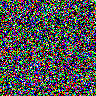

In [12]:
tensor = nt.randn(dict(height=96, width=96, channels=3))
tensor

Most simple operations simply keep around the named tensor properties. 

In [13]:
tensor.log().named_shape

OrderedDict([('height', 96), ('width', 96), ('channels', 3)])

### 2) Names as Accessors

The first benefit of names comes from the ability to replace the need for `dim` and `axis` style arguments entirely. For example, lets say we wanted to sort each column. 

OrderedDict([('height', 96), ('width', 96), ('channels', 3)])


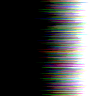

In [14]:
sorted_pic, _ = tensor.sort("width")
print(sorted_pic.named_shape)
sorted_pic.tensor

Another common operation is a *reduction*  where one or more dimensions is pooled out.   

OrderedDict([('height', 96), ('width', 96), ('channels', 3)])


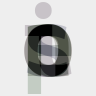

In [15]:
averaged_images = named_ims.mean("batch")
print(averaged_images.named_shape)
averaged_images

OrderedDict([('height', 96), ('width', 96)])


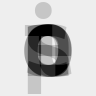

In [16]:
averaged_images = named_ims.mean("batch channels")
print(averaged_images.named_shape)
averaged_images

### 3) Broadcasting and Contraction

The names that are provided also provide the basis for broadcasting operations. When there is a binary operations between two named tensors they first ensure that all dimension are matched in name and then apply standard broadcasting. To demonstrate let's return to the masking example above. Here we simply declare the names of the dimensions of our mask, and ask the library to figure out the broadcasting. 

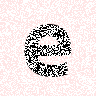

In [17]:
mask = NamedTensor(torch.randint(0, 2, [96, 96]).byte(), "height width")
named_ims.masked_fill(mask, 1).get("batch", 0)

Similar operations can be used for standard matrix operations such as addition and multiplication.

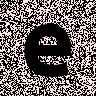

In [18]:
(named_ims * mask.double()).get("batch", 0)

Another useful feature is to the `contract` method which applies tensor contraction between two name tensors. Tensor contraction, the machinery behind `einsum`, is an elegant way of thinking about generalizations of dot-products.  

In [19]:
tensor1 = named_ims.get("batch", 0)
tensor2 = named_ims.get("batch", 0)


# Runs torch.einsum(ijk,ijk->jk, tensor1, tensor2)
print(tensor1.contract("height", tensor2).named_shape)

# Runs torch.einsum(ijk,ijk->il, tensor1, tensor2)
print(tensor1.contract("width", tensor2).named_shape)

# Runs torch.einsum(ijk,ijk->l, tensor1, tensor2)
print(tensor1.contract("height width", tensor2).named_shape)


OrderedDict([('width', 96), ('channels', 3)])
OrderedDict([('height', 96), ('channels', 3)])
OrderedDict([('channels', 3)])


Similar notation can be used for spare indexing. This is useful for embedding lookups and other sparse operations. 

OrderedDict([('lookups', 50), ('width', 96), ('channels', 3)])


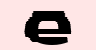

In [20]:
tensor1 = named_ims.get("batch", 0) 
tensor2, _ = NamedTensor(torch.randint(0, 96, [50]).long(), "lookups") \
             .sort("lookups")

# Select 50 random rows.
selected = tensor1.index_select("height", tensor2)
print(selected.named_shape)
selected

### 4) Transposition Should Be Explicit 

Behind the scenes all of the named tensors are acting as tensor objects. As such thing like order and stride of dimensions does matter. Operations like `transpose` and `view` are crucial for maintaining this, but are unfortunately quite error-prone. 
Instead I propose a single method `shift` that borrowsheavily from the Alex Rogozhnikov's excellent [einops](https://github.com/arogozhnikov/einops) package.
 

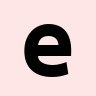

In [21]:
tensor = NamedTensor(ims[0], "h w c")
tensor

Standard calls to shift transpose dimensions.

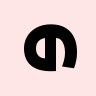

In [22]:
tensor.shift("w h c")

Calls with of the form "a -> (b c)" split dimensions, whereas "(a b) -> c" merge them. 

In [23]:
tensor = NamedTensor(ims[0], "h w c")
tensor.shift('h -> (height q)', height=8).named_shape

OrderedDict([('height', 8), ('q', 12), ('w', 96), ('c', 3)])

In [24]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift('(b h) -> bh').named_shape


OrderedDict([('bh', 576), ('w', 96), ('c', 3)])

Shifts can be chained in the same function.

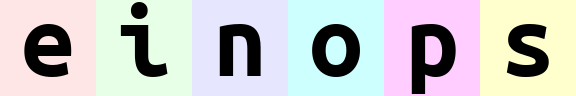

In [25]:
tensor.shift('(b w) -> bw', 'h bw c')


Just for fun, here are some of the crazier examples from *einops* in this notation.

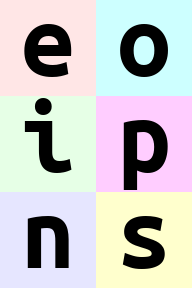

In [26]:
tensor.shift("b -> (b1 b2)", '(b2 h) -> a', '(b1 w) -> d', 'a d c', b1=2)

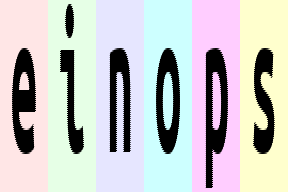

In [27]:
tensor.shift('w -> (w w2)', '(h w2) -> a', '(b w) -> d', 'a d c', w2=2)

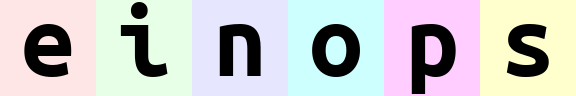

In [28]:
tensor.shift('(b w) -> a', 'h a c')

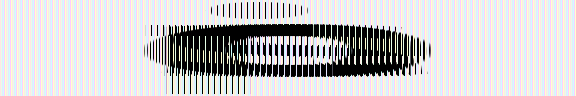

In [29]:
tensor.shift('(w b) -> a', 'h a c')

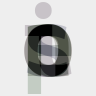

In [30]:
tensor = NamedTensor(ims, 'b h w c')
tensor.mean('b')

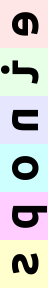

In [31]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift("h -> (h h2)", "w -> (w w2)", h2=2, w2=2).mean("h2 w2").shift("(b w) -> bw")

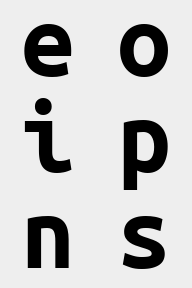

In [32]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift("b -> (b1 b2)", b1 = 2).mean('c').shift("(b1 w) -> bw", "(b2 h) -> bh", 'bh bw')


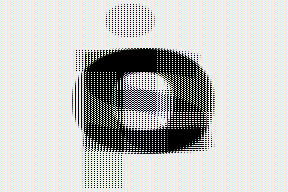

In [33]:
tensor.shift('b -> (b1 b2)', '(h b1) -> h', '(w b2) -> w', b1=2)

## 5) Less Indexing

Generally indexing is discouraged in this named tensor paradigm. Instead use functions like `index_select` above or `unbind`



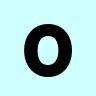

In [34]:
tensor = NamedTensor(ims, 'b h w c')

# Returns a tuple
images = tensor.unbind("b")
images[3]

Another alternative is to use `get` to obtain a single slice.

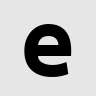

In [35]:
# Returns a tuple
images = tensor.get("b", 0).unbind("c")
images[1]

Finally `narrow` can be used to replace fancy indexing. However you must give a new dim name.

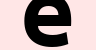

In [36]:
tensor.narrow( "h -> narrowedheight", 30, 50).get("b", 0)

## 6) Encapsulation

To demonstrate why these choices lead to better encapsulation properties, let's consider a real-world deep learning example. This example was proposed by my colleague Tim Rocktashel in the blog post describing einsum (https://rockt.github.io/2018/04/30/einsum).




Consider the problem of neural attention, which requires computing,

\begin{align*}
\mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})\otimes \mathbf{e}_L) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
\alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
\mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align*}

First let's setup the necessary parameters.

In [0]:
def random_ntensors(names, num=1, requires_grad=False):
    tensors = [nt.build(torch.randn, names, requires_grad=requires_grad)
               for i in range(0, num)]
    return tensors[0] if num == 1 else tensors

class Param:
    def __init__(self, in_hid, out_hid):
        torch.manual_seed(0)
        self.WY, self.Wh, self.Wr, self.Wt = \
            random_ntensors(dict(inhid=in_hid, outhid=out_hid),
                            num=4, requires_grad=True)
        self.bM, self.br, self.w = random_ntensors(dict(outhid=out_hid), num=3,
                                                   requires_grad=True)
        

Now consider the tensor-based einsum implementation of this function. 

In [0]:
# Einsum Implementation
import torch.nn.functional as F
def einsum_attn(params, Y, ht, rt1):
    # -- [batch_size x hidden_dimension]
    tmp = torch.einsum("ik,kl->il", [ht, params.Wh.tensor]) + \
          torch.einsum("ik,kl->il", [rt1, params.Wr.tensor])

    Mt = torch.tanh(torch.einsum("ijk,kl->ijl", [Y, params.WY.tensor]) + \
                tmp.unsqueeze(1).expand_as(Y) + params.bM.tensor)
    # -- [batch_size x sequence_length]
    at = F.softmax(torch.einsum("ijk,k->ij", [Mt, params.w.tensor]), dim=-1)

    # -- [batch_size x hidden_dimension]
    rt = torch.einsum("ijk,ij->ik", [Y, at]) + \
         torch.tanh(torch.einsum("ij,jk->ik", [rt1, params.Wt.tensor]) + 
                    params.br.tensor)

    # -- [batch_size x hidden_dimension], [batch_size x sequence_dimension]
    return rt, at

This implementation is a huge improvement over the naive PyTorch implementation. It removes many of the 
views and transposes that would be necessary to make this work. However, I would argue that it still fails many of 
the tests laid out in the introduction. It uses `squeeze`, it only works with one batch dim, and it is littered with comments that 
are not enforced as constraint in the code itself.

As an alternative consider the namedtensor version: 

In [0]:
def namedtensor_attn(params, Y, ht, rt1):
    tmp = ht.contract("inhid", params.Wh) + rt1.contract("inhid", params.Wr)
    at = (Y.contract("inhid", params.WY) + tmp + params.bM) \
         .tanh() \
         .contract("outhid", params.w) \
         .softmax("seqlen")

    rt = Y.contract("seqlen", at).shift("inhid -> (outhid)") + \
         (rt1.contract("inhid", params.Wt) + params.br).tanh()
    return rt, at


Note three things: 

1) The code never mentions "batch"

2) There is no indexing, unpacking of matrices, squeezes, or dim calls

3) If you understand attention, it is very clear where it is being computed and applied based on the `seqlen` name. 

In [0]:
in_hid = 7
out_hid = 7
Y = torch.randn(3, 5, in_hid)
# -- [batch_size x hidden_dimension]
ht, rt1 = torch.randn(3, in_hid), torch.randn(3, in_hid)
ea = Param(in_hid, out_hid)
r, a = einsum_attn(ea, Y, ht, rt1)

Y = NamedTensor(Y, "batch seqlen inhid")
ht = NamedTensor(ht, "batch inhid")
rt1 = NamedTensor(rt1, "batch inhid")
nr, na = namedtensor_attn(ea, Y, ht, rt1)

## Call to Action

Tools like NumPy and Torch not only help the community do research, they also drive forward what students think is plausible to try out. While it is true a lot of current models can be built fine with the tools we have, it seems implausible to me that the current programming practices are going to scale to new models. For instance, one space we have been working on recently is discrete latent variable models which often have many problem specific variables each with their own variable dimension. This setting breaks the current tensor paradigm almost immediately. 

That being said, this blog post is just a prototype of where this approach could go. If you are interested, I would love contributors to the build out this library properly. Some ideas if you want to send a PR to  [harvardnlp/namedtensor](https://github.com/harvardnlp/NamedTensor)!

1) **Extending beyond PyTorch**: Can we generalize this approach in a way that supports NumPy and Tensorflow?  


2) **Interacting with PyTorch Modules**: Can we "lift" PyTorch modules with type annotations, so that we know how they change inputs?


3) **Error Checking**: Can we add annotations to functions giving pre- and post -conditions so that dimensions are automatically checked.

